                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Feb 21 12:22:24 PM: Your problem has 2 variables, 1 constraints, and 0 parameters.
(CVXPY) Feb 21 12:22:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 21 12:22:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 21 12:22:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 21 12:22:24 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 21 12:22:24 PM: Compiling problem (target solver=SCS).
(CVXPY

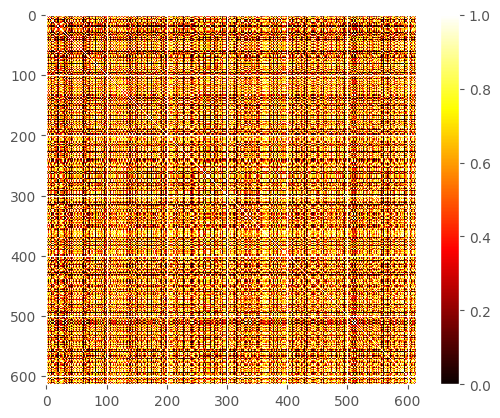

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
import pennylane as qml
import cvxpy as cp

# %% General configurations
np.random.seed(42)
plt.style.use('ggplot')

# %% Load and preprocess the dataset
df = pd.read_csv("diabetes_dataset.csv")
df = df.astype(float).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(["class"], axis=1),
    df["class"],
    test_size=0.2,
    random_state=42
)

# Drop constant columns
constant_columns = X_train.columns[X_train.nunique() == 1]
X_train = X_train.drop(columns=constant_columns)
X_test = X_test.drop(columns=constant_columns)

# Calculate correlations for clustering
correlations = X_train.corrwith(y_train)
correlations_reshaped = np.reshape(correlations.values, (-1, 1))

# Clustering features into groups
kmeans = KMeans(n_clusters=2, random_state=0).fit(correlations_reshaped)
clusters = kmeans.labels_
groups = [np.where(clusters == i)[0] for i in range(2)]

# Apply LDA for dimensionality reduction
features_lda = np.empty((X_train.shape[0], 2))
features_lda_test = np.empty((X_test.shape[0], 2))
for i, group in enumerate(groups):
    lda = LDA(n_components=1)
    features_lda[:, i] = lda.fit_transform(X_train.iloc[:, group], y_train).ravel()
    features_lda_test[:, i] = lda.transform(X_test.iloc[:, group]).ravel()

# Normalize features for QSVC
scaler_qsvc = StandardScaler().fit(features_lda)
X_train_qsvc = scaler_qsvc.transform(features_lda)
X_test_qsvc = scaler_qsvc.transform(features_lda_test)

# Update the number of qubits based on LDA output
n_qubits = X_train_qsvc.shape[1]

# Quantum device and encoding functions
dev = qml.device("lightning.qubit", wires=n_qubits)

def amplitude_encoding(x):
    return qml.AmplitudeEmbedding(x, wires=range(n_qubits), normalize=True, pad_with=0.)

def angle_encoding(x):
    return qml.AngleEmbedding(x, wires=range(n_qubits))

@qml.qnode(dev)
def kernel_circuit1(x):
    amplitude_encoding(x)
    return qml.state()

@qml.qnode(dev)
def kernel_circuit2(x):
    angle_encoding(x)
    return qml.state()

# Precompute quantum circuit outputs
def precompute_quantum_outputs(X, kernel_circuit):
    return np.array([kernel_circuit(x) for x in X])

# Precompute circuit outputs
X_train_circuit1 = precompute_quantum_outputs(X_train_qsvc, kernel_circuit1)
X_test_circuit1 = precompute_quantum_outputs(X_test_qsvc, kernel_circuit1)
X_train_circuit2 = precompute_quantum_outputs(X_train_qsvc, kernel_circuit2)
X_test_circuit2 = precompute_quantum_outputs(X_test_qsvc, kernel_circuit2)

# Define number of CPU cores to be used
n_jobs=10

# %% Compute kernel matrix using precomputed outputs with parallelization
def compute_kernel_matrix_parallel(precomputed_X1, precomputed_X2, n_jobs=n_jobs):
    """
    Computes the kernel matrix in parallel using joblib.
    """
    n_samples_1 = precomputed_X1.shape[0]
    n_samples_2 = precomputed_X2.shape[0]

    def kernel_value(i, j):
        # Compute the kernel value (similarity) for a pair of quantum states
        return np.abs(np.dot(precomputed_X1[i], precomputed_X2[j].conj())) ** 2

    # Generate all (i, j) index pairs
    pairs = [(i, j) for i in range(n_samples_1) for j in range(n_samples_2)]

    # Compute kernel values in parallel
    kernel_values = Parallel(n_jobs=n_jobs)(
        delayed(kernel_value)(i, j) for i, j in pairs
    )

    # Fill the kernel matrix
    kernel_matrix = np.zeros((n_samples_1, n_samples_2))
    for (i, j), value in zip(pairs, kernel_values):
        kernel_matrix[i, j] = value

    return kernel_matrix

# Compute kernel matrices
kernel_matrix1 = compute_kernel_matrix_parallel(X_train_circuit1, X_train_circuit1, n_jobs=n_jobs)
kernel_matrix2 = compute_kernel_matrix_parallel(X_train_circuit2, X_train_circuit2, n_jobs=n_jobs)

test_kernel_matrix1 = compute_kernel_matrix_parallel(X_test_circuit1, X_train_circuit1, n_jobs=n_jobs)
test_kernel_matrix2 = compute_kernel_matrix_parallel(X_test_circuit2, X_train_circuit2, n_jobs=n_jobs)

# %% Multiple Kernel Learning with Alignment
def compute_target_kernel(y):
    """
    Computes the target kernel matrix based on the labels.
    Each entry is the product of the labels for two data points.
    """
    labels = y.to_numpy().reshape(-1, 1)
    return labels @ labels.T

def optimize_kernel_weights(kernel_matrices, target_kernel):
    """
    Optimizes the weights for combining kernel matrices to maximize alignment with the target kernel.
    """
    n_kernels = len(kernel_matrices)

    # Define optimization variable for weights
    weights = cp.Variable(n_kernels, nonneg=True)  # Non-negative weights

    # Compute the combined kernel matrix as a weighted sum
    combined_kernel = sum(weights[i] * kernel_matrices[i] for i in range(n_kernels))

    # Define the alignment objective
    # Alignment = <K_combined, K_target> / (||K_combined||_F * ||K_target||_F)
    numerator = cp.trace(combined_kernel @ target_kernel)
    denominator = cp.norm(combined_kernel, "fro") * cp.norm(target_kernel, "fro")
    alignment = numerator / denominator

    # Define the optimization problem: maximize alignment
    objective = cp.Maximize(cp.trace(combined_kernel @ target_kernel))
    constraints = [cp.sum(weights) == 1]  # Weights must sum to 1
    problem = cp.Problem(objective, constraints)

    # Solve the optimization problem using DQCP mode
    problem.solve(qcp=True, solver=cp.SCS, max_iters=500000, eps=1e-6, verbose=True)


    # Return the optimized weights
    return weights.value

# Compute the target kernel matrix
target_kernel = compute_target_kernel(y_train)

# Optimize the weights for the kernel matrices
kernel_matrices = [kernel_matrix1, kernel_matrix2]
optimized_weights = optimize_kernel_weights(kernel_matrices, target_kernel)

# Combine the kernel matrices using the optimized weights
final_kernel_matrix = sum(w * K for w, K in zip(optimized_weights, kernel_matrices))
test_combined_kernel_matrix = sum(
    w * K_test for w, K_test in zip(optimized_weights, [test_kernel_matrix1, test_kernel_matrix2])
)

# %% Train and Evaluate the Model
svc = SVC(kernel="precomputed", probability=True, class_weight="balanced")
svc.fit(final_kernel_matrix, y_train)

# Evaluate the model 

# Predict on the test data
predictions_qsvc = svc.predict_proba(test_combined_kernel_matrix)[:, 1]

# Predict labels
y_pred = svc.predict(test_combined_kernel_matrix)

# Compute Accuracy
accuracy_test = accuracy_score(y_test, y_pred)

# Compute AUC
auc_test = roc_auc_score(y_test, predictions_qsvc)

# Compute KS Statistic
fpr, tpr, _ = roc_curve(y_test, predictions_qsvc)
ks_statistic = max(tpr - fpr)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test AUC: {auc_test:.4f}")
print(f"Test KS Statistic: {ks_statistic:.4f}")

# %% Visualization of the kernel matrix
def plot_kernel_matrix(kernel_matrix, title):
    plt.imshow(kernel_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()

plot_kernel_matrix(final_kernel_matrix, "")